## Feature Extraction and Machine-Learning With Pitchfork Reviews

In [189]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer as tbwToken
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from IPython.core import display
from sklearn.metrics import f1_score
import string
import numpy as np
import pandas as pd
import seaborn as sns
# a lot of imports

* Using word2vec we can find the cosine similarity of words 
* Using these word vectors we can use vector averaging to build recommendations using full reviews
* For expediency I've pretrained the model on our dataset. The process is fairly simple using genisms word2vec implementation.
* The model expects a list of sentences, for every sentence in our reviews data set I've stripped puncuation and tokenized the words.
* I settled on using 300 feautres per word, a minimum of 10 words, and a 10 word context window. 
* To tokenize the data I used nltk to parse the reviews for sentences and then tokenize and stem them. 


In [11]:
def tokenize(text):
    tbw= tbwToken() #our standford treebank based tokenizer
    sentences = text.replace("`","").replace("'","") #replace some additional characters
    sentences = sent_tokenize(sentences.encode("ascii","replace")) #make ascii safe
    tokens = [tbw.tokenize(s.lower()) for s in sentences]
    tokens = [stripPunc(t) for t in tokens]
    return tokens

def stripPunc(sent):
	tokens = []	
	for t in sent:
		if t not in string.punctuation: #list of punctuation characters
			tokens.append(t)
	return tokens

## Building a Recommendation Model

In [ ]:
sentences = [tokenize(s) for s in reviews[1]] #this is a demo of my script to create word vectors
reducedFat = reduce(lambda x,y: x+y, sentences) #list of lists converted to list

num_features = 300    # Word vector dimensionality                      
min_word_count = 10   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

model = Word2Vec(reducedFat, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

In [150]:
model = Word2Vec()
model.load("dataset/binaryFiles/300features_10minwords_102context")

* I trimmed the model
* If the complete memory subsists in memory, you can see fun stuff like this

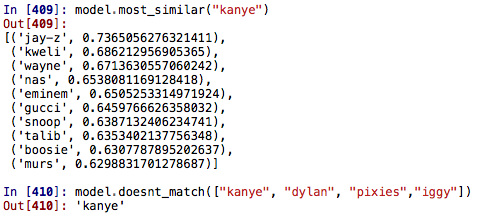

In [24]:
display.Image(filename="savedcharts/word2vecexample.png")

* Let's average the vectors in every review

In [3]:
def lambda_vectoraverage(review,model,num_features):
    featureVec = np.zeros((num_features,),dtype="float32") #empty numpy arrays for speed
    nwords = 0.
    modelindex = set(model.index2word) #sets are faster than arrays
    #this is the list of words in our word2vec trained model
    sentences = tokenize(review)
    for word in sentences:
        if word not in stopwords.words('english'): #imported from nltk
            if word in modelindex:
                nwords = nwords + 1.
                featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec,nwords)
    return featureVec #returns a 300x1 vector for every review

* After creating the vector averages we can find correlations to get recommendations
* I used a basic pearson correlation function to calculate the closest related reviews

In [15]:
def lambda_corr(vector,corr,df): #we input our wordvector, correlation metric, and datafram
    correlations = []
    for index,row in df.iterrows(): #itterows iterates over our dataframe
        correlation = corr(vector, row.vectorAverage) #row.vectorAverage == all vectors in dataframe
        artist = row.artist 
        album = row.album
        correlations.append([correlation[0],artist,album]) 
        #scipy's correlation returns a p-value and a correlation statistic, 0 is statistic
    correlations.sort(reverse=True) #to return all values sorted in descending order
    return correlations

In [186]:
Vecs = np.load('dataset/vectorsPitchfork.npy')
#I saved the vectors seperately in a numpy file
pfdata = pd.read_excel("dataset/FinalPFDataset.xlsx")

* Here is a test example using Kanye

In [197]:
pfdata["vectorAverage"] = Vecs
from scipy.stats import pearsonr
kanyeMask = pfdata["artist"]=="Kanye West"
KanyeAlbums = pfdata[kanyeMask==True]

In [6]:
KanyeAlbums[["BestNewMusic","album","artist","date","reviewScore"]]

,BestNewMusic,album,artist,date,reviewScore
1583,Best new music,Late Registration,Kanye West,Sun Aug 28 2005,9.5
3348,Best new music,The College Dropout,Kanye West,Fri Feb 20 2004,8.2
6585,Best new music,The Life of Pablo,Kanye West,Mon Feb 15 2016,9.0
9641,Best new music,Yeezus,Kanye West,Tue Jun 18 2013,9.5
12598,Best new music,My Beautiful Dark Twisted Fantasy,Kanye West,Mon Nov 22 2010,10.0
13672,Not Best New Music,VH1 Storytellers,Kanye West,Tue Jan 12 2010,4.9
14918,Not Best New Music,808s and Heartbreak,Kanye West,Tue Dec 02 2008,7.6
16410,Best new music,Graduation,Kanye West,Tue Sep 11 2007,8.7


In [16]:
KanyeCorr = lambda_corr(KanyeAlbums.iloc[2].vectorAverage,pearsonr,pfdata)

In [ ]:
KanyeCorr[1:9]

* These recommendations are rather obvious, but this is most helpful for less known artists
* Here is an example for a band called Wolf Parade
* I filtered to only recommend bands that received an 8 or higher

In [170]:
eightPlus = pfdata["reviewScore"] > 8
wolfparade = pfdata["artist"] == "Wolf Parade"
wfcorr = lambda_corr(pfdata[wolfparade == True].iloc[0].vectorAverage, pearsonr, pfdata[(eightPlus == True)])
pfdata[wolfparade == True]

,BestNewMusic,album,artist,author,date,fullReview,genre,reviewScore,ARI,CHARACTERS,...,GUNNING_FOG,SENTENCES,SMOG,SMOG_INDEX,SYLLABLES,WORDS,Sentiment_Score,Sentence_Count,genreMap,vectorAverage
1489,Best new music,Apologies to the Queen Mary,Wolf Parade,Brandon Stosuy,Sun Sep 25 2005,Considering the amount of pre-release talk sur...,Rock,9.2,23.894,2398,...,23.6,11,17.540,16.817,795,508,-1.00,60,2,"[-0.0241601, -0.319186, 0.321626, 0.0784713, 0..."
1759,Not Best New Music,Wolf Parade EP,Wolf Parade,Brandon Stosuy,Thu Jul 07 2005,"\nA forerunner of the great ""Wolf"" bandnaming ...",Rock,7.1,16.874,2299,...,18.0,15,14.743,14.136,759,502,1.01,28,2,"[-0.0789229, -0.507792, 0.323683, 0.0870902, 0..."
13078,Not Best New Music,Expo 86,Wolf Parade,Paul Thompson,Tue Jun 29 2010,"On their third full-length, the indie supergro...",Rock,7.5,15.337,2382,...,17.2,17,14.213,13.627,778,529,0.77,33,2,"[-0.126524, -0.410159, 0.32123, 0.167879, 0.03..."
15484,Not Best New Music,At Mount Zoomer,Wolf Parade,Amanda Petrusich,Tue Jun 17 2008,"The two distinct, exceptional songwriters in W...",Rock,7.7,14.652,2304,...,15.2,17,11.670,11.189,750,528,-0.29,22,2,"[-0.00422521, -0.339925, 0.310759, 0.0736794, ..."


In [172]:
wfcorr.sort(reverse=True)
wfcorr[1:9]

[[0.94396746, u'Sunset Rubdown', u'Shut Up I Am Dreaming'],
 [0.93364722, u'Andrew Cedermark', u'Moon Deluxe'],
 [0.93152463, u'Local Natives', u'Gorilla Manor'],
 [0.92846596, u'Local Natives', u'Hummingbird'],
 [0.92174828, u'Sunset Rubdown', u'Dragonslayer'],
 [0.92073423, u'Dirty Projectors', u'Swing Lo Magellan'],
 [0.91899276, u'Chelsea Wolfe', u'Abyss'],
 [0.91734266, u'Handsome Furs', u'Sound Kapital']]

* Spencer Krug the leader singer is also in Sunset Rubdown and the Handsome Furs so these are very good

In [190]:
wfcorr[-20:] #the least likely to be recommended

[[0.56777954, u'Various Artists', u'Hyperdub 10.1'],
 [0.5642488, u'Miles Davis', u'Bitches Brew [Legacy Edition]'],
 [0.56377083,
  u'Miles Davis',
  u'Miles at the Fillmore - Miles Davis 1970: The Bootleg Series Vol. 3'],
 [0.56376195, u'Oneohtrix Point Never', u'R Plus Seven'],
 [0.56257361, u'Babatunde Olatunji', u'Drums of Passion'],
 [0.55642694, u'Patrick Cowley', u'School Daze'],
 [0.5537625,
  u'Africa Express',
  u"Africa Express Presents... Terry Riley's In C Mali"],
 [0.55162525, u'The Delgados', u'The Complete BBC Peel Sessions'],
 [0.55123949, u'Blu', u'NoYork!'],
 [0.54992557, u'Cybotron', u'Enter'],
 [0.54337227, u'Kelela', u'Cut 4 Me'],
 [0.54318136,
  u'Vijay Iyer / Wadada Leo Smith',
  u'A Cosmic Rhythm With Each Stroke'],
 [0.54108244,
  u'Various Artists',
  u'I Heard The Angels Singing: Electrifying Black Gospel'],
 [0.54021144,
  u'K. Leimer',
  u'A Period of Review (Original Recordings: 1975-1983)'],
 [0.53996092,
  u'Various Artists',
  u'I Am The Center: Priva

* Glancing at this list, the recommendation engine thinks that jazz and electronic music listeners probably would not like this band
* Given that the correlation is still rather high, we may want to investigate if this an artifact of the writing style or if we should set a greater downsampling for our word2vec threshold

## Predicting Best New Music Using Machine Learning

* To create a predictive model, we can use both our vectors and a bag of words model
* Bag of words creates a spreadsheet like representation of a number of different words, in this case 1000
* We will transform this with tf-idf, term frequency, inverse document frequency. This will give additional statistical power to our "Best New Music" class which is comparitively rare

In [192]:
stemmer = PorterStemmer() #porter stemmer to stem all tokens

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tbw= tbwToken() #our standford treebank based tokenizer
    clean_review = text.replace("``","").replace("''","").replace("'","").replace("--",'') #replace some additional characters
    clean_sentence = sent_tokenize(clean_review.encode("ascii","ignore")) #make ascii safe
    clean_sentence_punc = [c.translate(None, string.punctuation) for c in clean_sentence]
    #remove puncuations from sentences
    tokens = reduce(lambda x,y : x+y, [tbw.tokenize(s) for s in clean_sentence_punc])
    #tokenize and return list
    stems = stem_tokens(tokens, stemmer)
    #stem tokens
    return stems

encode = {"Best new music":0, "Not Best New Music":1}

pfdataTrain = pd.read_excel('/Users/dheepan.ramanan/Documents/PitchforkAnalysis/dataset/trainingData/pfdataTrain.xlsx')

reviews = pfdataTrain.fullReview
vect = CountVectorizer(tokenizer=tokenize, stop_words=stopwords.words('english'),min_df=5,max_features=1000,ngram_range=(1,2))
transformer = TfidfTransformer( smooth_idf=True, sublinear_tf=False, use_idf=True)
#call the CountVectorier and TFIDF transformer

xdata = pfdataTrain.drop(["artist","fullReview","date","album","author","genre","reviewScore"],axis=1).dropna()
#open our training set and drop string columns and review score 
vecBow = vect.fit_transform(reviews)
vecBowT = transformer.fit_transform(vecBow)
#transform our dataset

* We now have a spare representation of our bag of words model
* In the next section we will encode our labels and join our bag of words model to our vectors and statistical features we found in our data exploration 

In [200]:
BoW = pd.DataFrame(vecBowT.todense(),columns=[vect.get_feature_names()])
#To join our bag of words data easily I will convert it to a pandas dataframe
ytrain = xdata["BestNewMusic"].apply(lambda x: encode[x]) #apply dictionary map
xtrain = pd.DataFrame(xdata.drop("BestNewMusic",axis=1).dropna(),columns=xdata.columns[1:])
selectedColumns = ['ARI', 'CHARACTERS', 'COLEMAN_LIAU',
       'COMPLEXWORDS', 'FLESCH_KINCAID', 'FLESCH_READING', 'GUNNING_FOG',
       'SENTENCES', u'SMOG', u'SMOG_INDEX', 'SYLLABLES', 'WORDS',
       'Sentiment_Score', 'Sentence_Count','NumAlbums','AlbumChron']
genreCols = ['Electronic', 'Experimental','Folk/Country', 'Global', 'Jazz', 'Metal', 'Pop/R&B', 'Rap','Rock']
xtrainScaled = pd.DataFrame(StandardScaler().fit_transform(xtrain[selectedColumns]),columns=selectedColumns)
# to ensure normalization I will scale all of our numerical features
xtrainScaled["vectorAverage"] = pfdata["vectorAverage"]
xtrainScaled = xtrainScaled.join(xtrain[genreCols])

In [201]:
npVecs = xtrainScaled["vectorAverage"].values.tolist()
# our list of 300 x 1 word vectors
VecDfs = pd.concat([pd.DataFrame(narray).T for narray in npVecs]).reset_index().drop("index",axis=1).fillna(0)
VecDfs.columns = ["vector_"+str(i) for i in range(300)]

In [202]:
xtrainScaled = xtrainScaled.drop("vectorAverage",axis=1).reset_index().fillna(0).drop("index",axis=1)
xtrainScaledVB = xtrainScaled.join(BoW).fillna(0)

In [203]:
confusionMatrixTrain = {}
modelStats= {}
classifiers = [LogisticRegression(penalty="l1"), LogisticRegression(penalty="l2"),LinearSVC(penalty="l1",dual=False),LinearSVC(penalty="l2"),RandomForestClassifier(n_estimators=100)]
for c in classifiers:
	c.fit(xtrainScaledVB,ytrain)
	score = cross_val_score(c, xtrainScaledVB.values, ytrain, cv=3, scoring="f1",n_jobs=1)
	cm = confusion_matrix(ytrain,c.predict(xtrainScaledVB.values))
	modelStats[c] = score
	confusionMatrixTrain[c] = cm

In [204]:
modelStats

{LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0): array([ 0.9798303 ,  0.97883008,  0.97811847]),
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
      verbose=0): array([ 0.9798303 ,  0.97982468,  0.97939866]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False): array([ 0.9798303 ,  0.97982468,  0.97982468]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_

In [205]:
confusionMatrixTrain

{LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0): array([[    7,   428],
        [    1, 10563]]),
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
      verbose=0): array([[    0,   435],
        [    0, 10564]]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False): array([[    0,   435],
        [    0, 10564]]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr',

* All of our algorithims had similar f-scores, but the Random Forests Classifier failed spectacularly at classifying any Best New Music 
* Likely the decision trees are overfitting to the default class
* Support Vectors with l1, and the two Logistic Regression models scores the best

In [206]:
xtest = pd.read_excel('/Users/dheepan.ramanan/Documents/PitchforkAnalysis/dataset/trainingData/pfdataTest.xlsx').drop(["artist","date","album","author","genre","reviewScore"],axis=1).reset_index().drop("index",axis=1)
xtest = xtest.join(pfdata["vectorAverage"])

In [207]:
testBow = vect.transform(xtest.fullReview)
testBow = transformer.fit_transform(testBow)
testBoW = pd.DataFrame(testBow.todense(),columns=[vect.get_feature_names()])

In [208]:
npVecsTest = xtest["vectorAverage"].values.tolist()
VecDfsTest = pd.concat([pd.DataFrame(narray).T for narray in npVecsTest]).reset_index().drop("index",axis=1).fillna(0)
VecDfs.columns = ["vector_"+str(i) for i in range(300)]

In [209]:
xtestScaled = pd.DataFrame(StandardScaler().fit_transform(xtest[selectedColumns]),columns=selectedColumns)
xtestScaled = xtestScaled.join(xtest[genreCols])

xtestScaled = xtestScaled.reset_index().fillna(0).drop("index",axis=1)
xtestScaledVB = xtestScaled.join([BoW,VecDfs]).fillna(0)
ytest = xtest["BestNewMusic"].apply(lambda x: encode[x])

In [210]:
F1Test = {}
confusionMatrixTest = {}
for c in classifiers:
	c.fit(xtestScaledVB.values,ytest)
	ypred = c.predict(xtestScaledVB.values)
	cm = confusion_matrix(ytest,ypred)
	f1= f1_score(ytest,ypred)
	F1Test[c] = f1
	confusionMatrixTest[c] = cm 

In [211]:
F1Test

{LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0): 0.98503889886295626,
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
      verbose=0): 0.98116356700047691,
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False): 0.98092967818831944,
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.000

In [212]:
confusionMatrixTest

{LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0): array([[  35,  125],
        [   0, 4115]]),
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
      verbose=0): array([[   2,  158],
        [   0, 4115]]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False): array([[   0,  160],
        [   0, 4115]]),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
 

* Supper Vectors with l1 penalty, and the two Logistic Regression models score the best
* Our model is performing very strongly, scoring 100% of best new music
* Let's look at the feature strength in the logistic regression model

In [213]:
LogReg = LogisticRegression(penalty="l2")

In [214]:
LogReg.fit(xtestScaledVB.values,ytest)
ypredlog = LogReg.predict(xtestScaledVB.values)
fscore = f1_score(ytest,ypredlog)
fscore

0.98092967818831944

In [215]:
featuresLog = pd.DataFrame(LogReg.coef_,columns=xtestScaledVB.columns).T
featuresLog.columns = ["coef"]
featuresLog["absolute"] = features.coef.apply(lambda x: np.absolute(x))
%matplotlib inline

## Top Best New Music Features

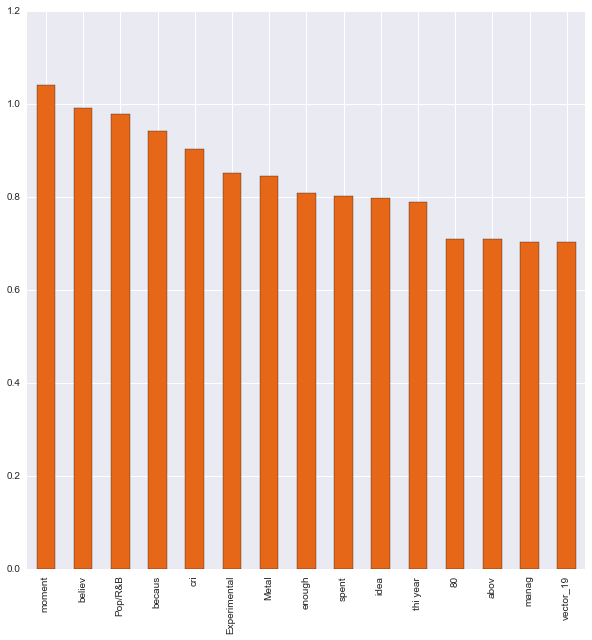

In [232]:
featuresLog.sort_values("coef",ascending=True)['coef'].apply(lambda x: x*-1).head(15).plot.bar(figsize=(10,10),color="#E56717")

* Our genre indicators proved to be useful
* Pop/R&B, Experimental, and Metal are all among the strongest features
* This is likely because these albums reviewed less often, but over perform when they are reviews
* Moment, believe, crying, idea, enough are also indicators
* Interestingly "80's" is a top feature for best new music. Which shows some of the music trends in electronic music

## Top Features Indicating Not Best Music

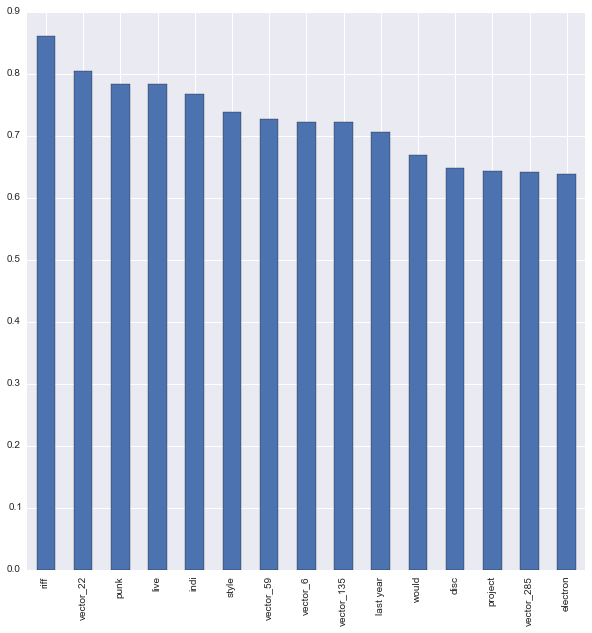

In [222]:
featuresLog.sort_values("coef",ascending=False).head(15)['coef'].plot.bar(figsize=(10,10))

* Riff is the most important feature in describing music that generally does not make best new music
* Punk, live, and indie are also in the top 5.
* Among feature that indicate "not best music", vector averages are generally more influential. 